In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt


In [2]:
# Set paths
train_dir = '/Users/gauravsingh/Downloads/Plant Detection/train'
test_dir = '/Users/gauravsingh/Downloads/Plant Detection/test'

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Get class names in consistent order
class_names = list(train_generator.class_indices.keys())

# Load validation generator using same class ordering
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=class_names
)

# Load test generator using same class ordering
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=class_names
)

# Print check
print("Train classes:", train_generator.num_classes)
print("Validation classes:", val_generator.num_classes)
print("Test classes:", test_generator.num_classes)


Found 2149 images belonging to 28 classes.
Found 521 images belonging to 28 classes.
Found 252 images belonging to 28 classes.
Train classes: 28
Validation classes: 28
Test classes: 28


In [3]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_model((img_height, img_width, 3), train_generator.num_classes)


In [4]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 61s 845ms/step - accuracy: 0.0532 - loss: 3.5709 - val_accuracy: 0.0998 - val_loss: 3.1951
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 58s 806ms/step - accuracy: 0.1116 - loss: 3.1433 - val_accuracy: 0.1324 - val_loss: 3.0234
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 814ms/step - accuracy: 0.1409 - loss: 2.9956 - val_accuracy: 0.1401 - val_loss: 2.9602
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 60s 830ms/step - accuracy: 0.1905 - loss: 2.8765 - val_accuracy: 0.1843 - val_loss: 2.8916
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 60s 830ms/step - accuracy: 0.1965 - loss: 2.7871 - val_accuracy: 0.1747 - val_loss: 2.9004


In [5]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")



8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.0758 - loss: 3.1495
Test Accuracy: 9.92%


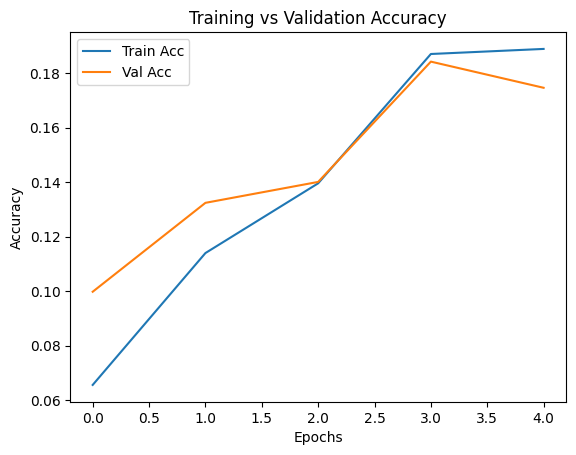

In [6]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


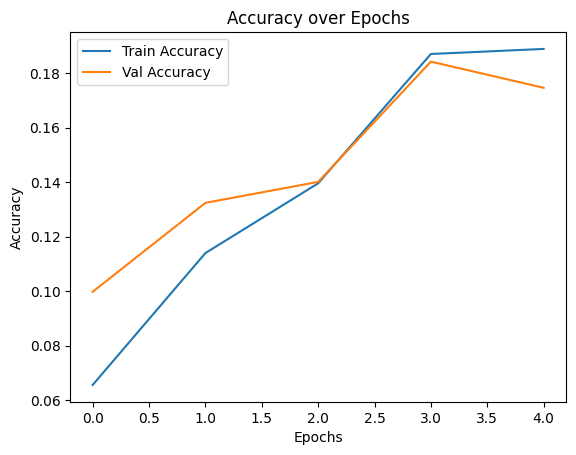

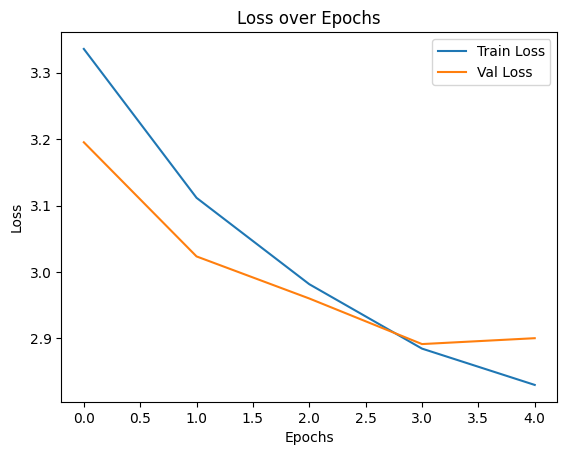

In [7]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
model.save('plant_disease_model.h5')


In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/Users/gauravsingh/Downloads/Plant Detection/train/Apple_rust_leaf/train_Apple rust leaf_2.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: Tomato_Septoria_leaf_spot


In [11]:
import os

for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} images")


Apple_rust_leaf: 96 images
Tomato_leaf_mosaic_virus: 44 images
Bell_pepper_leaf: 34 images
Blueberry_leaf: 106 images
Tomato_leaf: 44 images
Tomato_leaf_yellow_virus: 223 images
Corn_rust_leaf: 107 images
Bell_pepper_leaf_spot: 74 images
Strawberry_leaf: 88 images
Tomato_two_spotted_spider_mites_leaf: 2 images
Tomato_Early_blight_leaf: 79 images
Apple_Scab_Leaf: 83 images
Potato_leaf_late_blight: 200 images
Peach_leaf: 103 images
Tomato_leaf_late_blight: 101 images
Squash_Powdery_mildew_leaf: 124 images
grape_leaf: 63 images
Tomato_mold_leaf: 85 images
Soyabean_leaf: 57 images
Tomato_Septoria_leaf_spot: 145 images
grape_leaf_black_rot: 71 images
Tomato_leaf_bacterial_spot: 101 images
Potato_leaf_early_blight: 157 images
Corn_leaf_blight: 182 images
Corn_Gray_leaf_spot: 63 images
Cherry_leaf: 47 images
Raspberry_leaf: 112 images
Apple_leaf: 79 images


In [12]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict
)


Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 61s 835ms/step - accuracy: 0.1904 - loss: 2.9948 - val_accuracy: 0.0864 - val_loss: 3.1077
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.1482 - loss: 3.0156 - val_accuracy: 0.1459 - val_loss: 3.0506
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.1913 - loss: 2.8328 - val_accuracy: 0.1440 - val_loss: 2.9921
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 61s 848ms/step - accuracy: 0.2077 - loss: 2.7963 - val_accuracy: 0.1727 - val_loss: 2.9752
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 66s 929ms/step - accuracy: 0.2241 - loss: 2.5913 - val_accuracy: 0.1344 - val_loss: 3.0669
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 64s 900ms/step - accuracy: 0.1947 - loss: 2.5028 - val_accuracy: 0.1459 - val_loss: 3.0502
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 63s 886ms/step - accuracy: 0.2392 - loss: 2.4842 - val_accuracy: 0.1881 - val_loss: 2.9854
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 71s 988ms/step - accuracy: 0.2656 - loss: 2.3789 - val_accuracy: 

In [13]:
pred = model.predict(img_array)
print("Probabilities:", pred)
print("Predicted class index:", np.argmax(pred))
print("Class name:", class_names[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Probabilities: [[3.00981198e-02 5.39599825e-03 5.17532937e-02 1.89353209e-02
  2.97251586e-02 3.77451219e-02 1.91328023e-03 1.10745681e-02
  3.36896293e-02 2.29497417e-03 1.01508871e-02 6.46115541e-02
  4.93253246e-02 2.08302438e-02 3.01296432e-02 1.20130266e-04
  1.01941228e-01 5.44124618e-02 1.42466053e-01 3.25878803e-03
  1.40703425e-01 1.75362714e-02 2.89391559e-02 3.95944389e-03
  3.30759026e-02 5.37735736e-03 3.43008037e-03 6.71065822e-02]]
Predicted class index: 18
Class name: Tomato_Septoria_leaf_spot


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - accuracy: 0.0183 - loss: 3.7864
Test Accuracy: 3.57%


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step


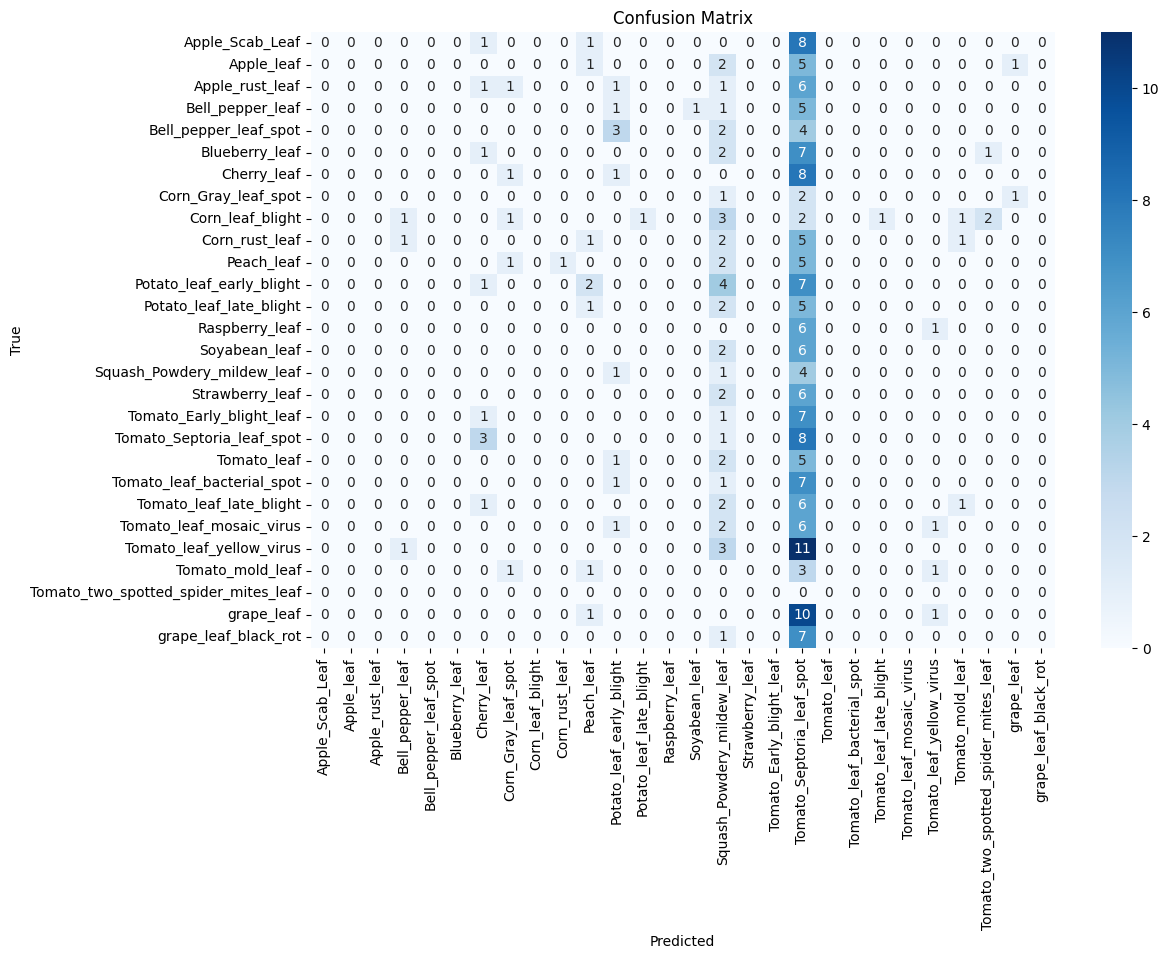

                                      precision    recall  f1-score   support

                     Apple_Scab_Leaf       0.00      0.00      0.00        10
                          Apple_leaf       0.00      0.00      0.00         9
                     Apple_rust_leaf       0.00      0.00      0.00        10
                    Bell_pepper_leaf       0.00      0.00      0.00         8
               Bell_pepper_leaf_spot       0.00      0.00      0.00         9
                      Blueberry_leaf       0.00      0.00      0.00        11
                         Cherry_leaf       0.00      0.00      0.00        10
                 Corn_Gray_leaf_spot       0.00      0.00      0.00         4
                    Corn_leaf_blight       0.00      0.00      0.00        12
                      Corn_rust_leaf       0.00      0.00      0.00        10
                          Peach_leaf       0.00      0.00      0.00         9
            Potato_leaf_early_blight       0.00      0.00      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


In [19]:
model.save("plant_disease_model.h5")


In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Predicted class: {predicted_class} ({confidence*100:.2f}%)")


In [21]:
predict_image('/Users/gauravsingh/Downloads/Plant Detection/train/Apple_rust_leaf/train_Apple rust leaf_2.jpg', model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
Predicted class: Tomato_Septoria_leaf_spot (14.88%)
